In [430]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 14})

In [431]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.4.1


In [432]:
import tensorflow_addons as tfa

In [433]:
import wispy.callbacks

In [434]:
def make_data(x):
    
    a = 4*np.pi
    # target function derivative w.r.t x
    y = np.cos(x*a)
#     y = x**3
    
    # target function derivative w.r.t time
    dy = -np.sin(x*a)*a
#     dy = 3*x**2
    
    return x.reshape(-1, 1), y.reshape(-1, 1), dy.reshape(-1, 1)

In [435]:
x_input_train = np.arange(0, 1, 0.01)
diff = (x_input_train[1] - x_input_train[0])/2
x_input_val = x_input_train + diff

In [436]:
x_input_train-x_input_val

array([-0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005, -0.005,
       -0.005, -0.005, -0.005, -0.005])

In [437]:
x, y, dy = make_data(x_input_train)
x_val, y_val, dy_val = make_data(x_input_val)

Text(0.5, 1.0, 'derivative target function')

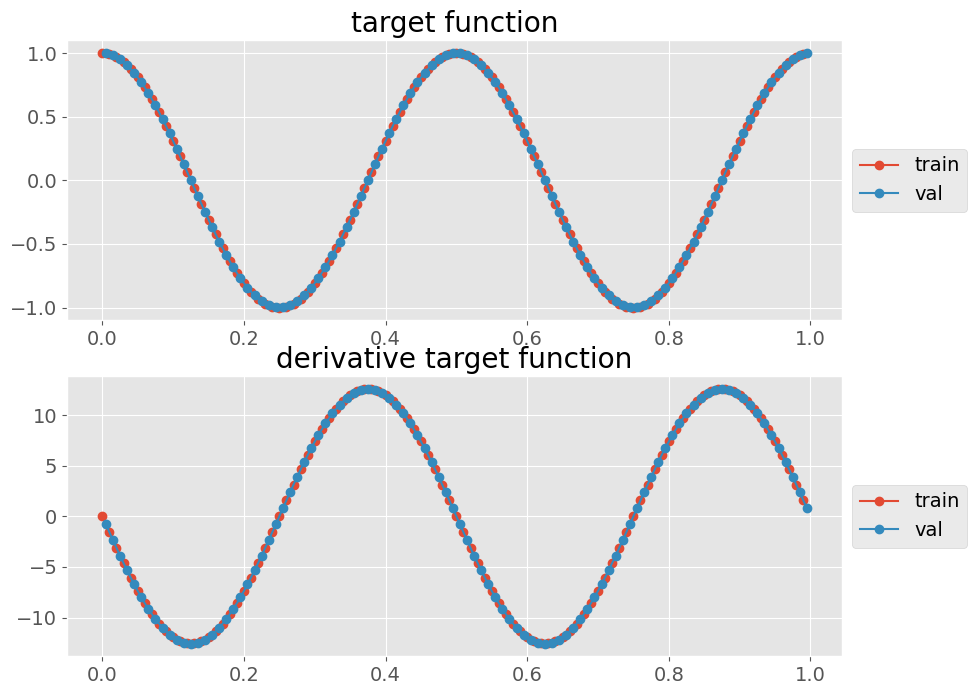

In [438]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(x, y, 'o-', label='train')
plt.plot(x_val, y_val, 'o-', label='val')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("target function")

plt.subplot(2, 1, 2)
plt.plot(x, dy, 'o-', label='train')
plt.plot(x_val, dy_val, 'o-', label='val')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("derivative target function")

In [439]:
def build_base_model(input_shape, output_shape, width, depth, act='relu'):
#     init = tf.keras.initializers.GlorotUniform()
    init = tf.keras.initializers.GlorotNormal()
    
    inputs = keras.Input(shape=(input_shape,))
    x = layers.Dense(width, activation=act, kernel_initializer=init)(inputs)
    for i in range(depth):
        x = layers.Dense(width, activation=act, kernel_initializer=init)(x)
    outputs = layers.Dense(output_shape)(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=f"base_model")
    return model

In [452]:
x.shape

(100, 1)

In [453]:
%%time
model = build_base_model(input_shape=x.shape[1], output_shape=y.shape[1], width=128, depth=5, act='relu')
opt = tf.optimizers.Adam(learning_rate=1e-3)
# opt = tf.optimizers.Adam(learning_rate=1e-3, clipvalue=100)
# opt = tf.optimizers.Adam(learning_rate=1e-3, clipnorm=0.01)
model.compile(loss='mse', optimizer=opt)
callbacks=[]
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

callbacks.append(wispy.callbacks.ThresholdCallback(1e-9))

history = model.fit(x, y, validation_data=(x_val, y_val), epochs=1000, verbose=0, callbacks=callbacks, batch_size=100)

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

CPU times: user 43.6 s, sys: 2.79 s, total: 46.3 s
Wall time: 42.3 s


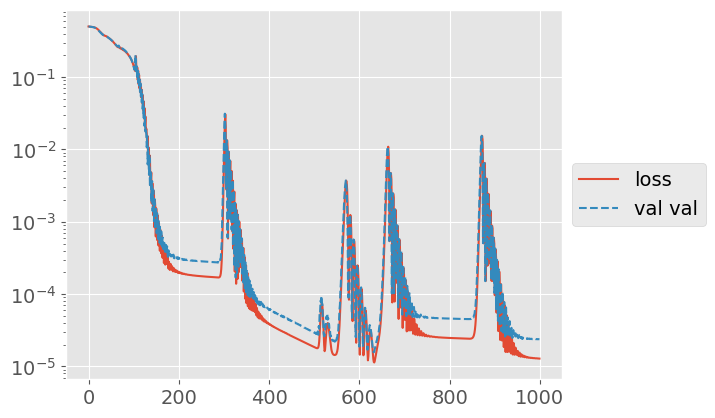

In [454]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val val', ls='--')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')

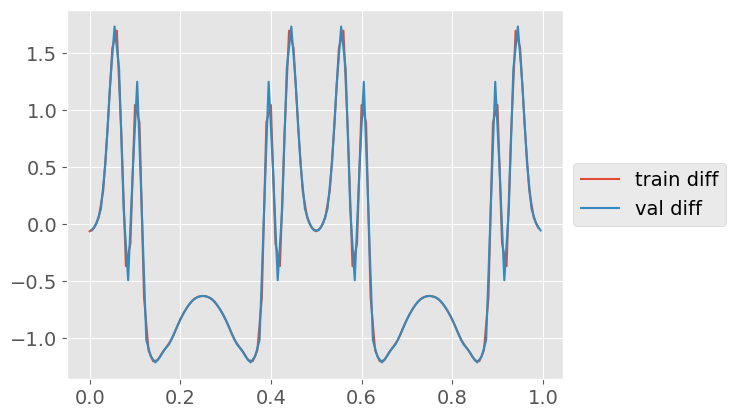

In [455]:
plt.figure()
plt.plot(x, y-model.predict(y), label='train diff')
plt.plot(x_val, y_val-model.predict(y_val), label='val diff')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [456]:
def compute_gradient_from_model(x, model):
    """
    derivative of model
    https://www.tensorflow.org/guide/autodiff
    https://stackoverflow.com/a/59147703/12840171
    """
    x = tf.convert_to_tensor(x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)

    dy_dx = tape.gradient(y, x)
    
    return dy_dx

In [457]:
x_prime = np.arange(0,1,1e-4).reshape(-1, 1)
# x_prime = np.array([0.]).reshape(-1, 1)
# x_prime = tf.convert_to_tensor(x_prime)
print(x_prime.shape)

dy_hat = compute_gradient_from_model(x_prime, model)

(10000, 1)


In [458]:
dy_hat[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.90002584])>

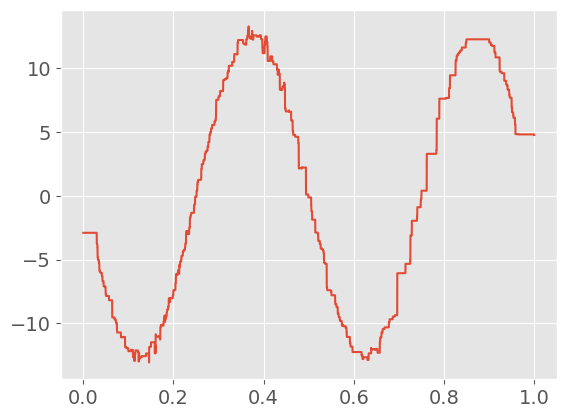

In [459]:
plt.figure()
plt.plot(x_prime, dy_hat)

In [460]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(x,y, 'o-', label='train')
plt.plot(x_val,y_val, 'o-', label='val')

plt.plot(x_prime, model.predict(x_prime), label='dense prediction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("target function")

plt.subplot(2, 1, 2)
plt.plot(x, dy, 'o-', label='train')
plt.plot(x_val, dy_val, 'o-', label='val')

plt.plot(x_prime, compute_gradient_from_model(x_prime, model), label='dense derivative prediction')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("derivative target function")

Text(0.5, 1.0, 'derivative target function')